# 连接数据库SQLite

## 准备数据
 之前的章节我们已经测试了Request API接口，并且把代码做了规范化处理。本节练习中，我们需要先把一些函数从notebook中导出到py文件中，这样就可以复用了。
 
***需要注意的是: Pycharm中软件帮我们设置了项目的根目录，并且把根目录包含在系统path中。所以当我们用import导入时，python可以找到我们自己写的模块。 这里我们采用的是原生的jupyter notebook，需要手动将我们的模块添加到系统path中。一种方法是手动添加到环境变量中，这是永久方法。还有一种方法是添加临时path。本文就是采用后一种方式。***


In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

C:\Users\renb\PycharmProjects\weather_dashapp\weather_book


## 项目结构
```
weather_book
├───.ipynb_checkpoints
├───data
├───steps  <-- notebook 主要在这里
├───weather_app
│   ├───models    <-- 函数写在这里

```
添加完path之后，就可以导入自己的模块了。 注意如果是上面的路径中采用的“..”,说明只返回上一层，如果是“../..",说明返回了两层。 
返回一层和两层对我的项目的区别是，以下代码是否需要包含weather_book。
如果只返回一层，系统可以直接找到weather_app 模块，但是无法找到weather_book（因为已经在weather_book模块内了，不识模块真面目，只缘身在此山中）。

In [2]:
from weather_app.models.query_api import get_geo_from_city,generate_url,request_weather_info,transform_weather_raw,add_city_info

一个好的习惯是，对你的函数进行快速测试。

In [3]:
city = 'shanghai'
lon, lat = get_geo_from_city(city)
url = generate_url(lon, lat)
text_j = request_weather_info(url)
weather_info_df = transform_weather_raw(text_j)
weather_info_df = add_city_info(weather_info_df, lon, lat, city)
weather_info_df

,cloudcover,lifted_index,prec_type,prec_amount,temp2m,rh2m,weather,timestamp,wind_direction,wind_speed,longitude,latitude,city
0,9,15,none,1,4,89,cloudynight,2022-02-02 21:00:00,NE,3,121.469207,31.232276,shanghai
1,9,15,rain,1,4,69,lightrainday,2022-02-03 00:00:00,NE,3,121.469207,31.232276,shanghai
2,9,15,none,1,5,51,cloudyday,2022-02-03 03:00:00,NE,3,121.469207,31.232276,shanghai
3,9,15,none,1,5,51,cloudyday,2022-02-03 06:00:00,NE,3,121.469207,31.232276,shanghai
4,9,15,rain,1,5,60,lightrainday,2022-02-03 09:00:00,NE,3,121.469207,31.232276,shanghai
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,7,15,rain,4,5,50,rainday,2022-02-10 06:00:00,NW,2,121.469207,31.232276,shanghai
60,6,15,none,4,6,55,mcloudyday,2022-02-10 09:00:00,NW,2,121.469207,31.232276,shanghai
61,5,15,none,4,6,62,pcloudynight,2022-02-10 12:00:00,W,3,121.469207,31.232276,shanghai
62,7,15,none,4,6,71,mcloudynight,2022-02-10 15:00:00,SW,3,121.469207,31.232276,shanghai


## 引入SQLite
我们可以使用任意的关系数据库保存这些数据，但是这里我强烈推荐SQLite，因为它轻量，无无服务器，免安装，开箱即用。对于新手来说，完全是无痛体验。
但是它支持标准的SQL查询语言的功能，我们一样可以用它练习数据库的增删查操作。

如果想快速入门，可以参考中文网站：
https://www.runoob.com/sqlite/sqlite-intro.html#:~:text=SQLite%E6%98%AF%E4%B8%80%E4%B8%AA%E8%BF%9B%E7%A8%8B%E5%86%85,%E7%9B%B4%E6%8E%A5%E8%AE%BF%E9%97%AE%E5%85%B6%E5%AD%98%E5%82%A8%E6%96%87%E4%BB%B6%E3%80%82

## 使用 SQLAlchemy
我们已经选择了SQLite 作为我们的数据库，作为“客户端”python和数据库之间的衔接，我们可以选择很多库，这里推荐的是SQLAlchemy。
这里对 SQLAlchemy做一个简单介绍，SQLAlchemy 是用于处理数据库和Python的工具。他的主要组成其实是两部分：core和ORM。 core属于低阶API，ORM属于高阶API。也就是说，ORM建立在Core上。


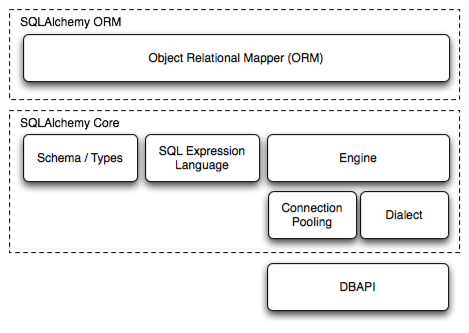
首先我们需要安装SQLAlchemy，采用pip安装。

```pip install sqlalchemy```

https://docs.sqlalchemy.org/en/14/tutorial/index.html

首先我们需要建立对话，调用create_engine 函数。对于SQLite 来说，URL格式就是本地数据库（文件）的路径，这里我需要在当前文件夹生成这个数据库，所以不会添加其他相对路径，只有一个文件名而已。

In [4]:
from sqlalchemy import create_engine

In [5]:
engine = create_engine('sqlite:///weather.db')

In [6]:
engine

Engine(sqlite:///weather.db)

想要做增删查的操作，就需要建立一个Session会话。这样我们就有一个session为我们敞开大门，等着我们进行操作。

In [7]:
from sqlalchemy.orm import Session

In [8]:
session = Session(engine)

In [9]:
session

## 使用ORM 管理表
The Declarative Mapping is the typical way that mappings are constructed in modern SQLAlchemy. The most common pattern is to first construct a base class using the declarative_base() function, which will apply the declarative mapping process to all subclasses that derive from it. (https://docs.sqlalchemy.org/en/20/orm/mapping_styles.html)

Refering to DataFrame structure, we create a Python class and include each column in DataFrame as attribute in class.
Each class attribute indicates specific column in the table.

In [10]:
# create database table by defining python class
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column,Integer,String,Float
Base = declarative_base()


In [11]:
class WeatherInfo(Base):
    __tablename__ = 'weather'
    __table_args__ = {'extend_existing': True}
    id = Column(Integer,primary_key=True,autoincrement=True)  # use autoincrement
    timestamp = Column(String(55))
    cloudcover = Column(Integer)
    lifted_index = Column(Integer)
    prec_type = Column(String(10))
    prec_amount = Column(Integer)
    temp2m = Column(Integer)
    rh2m = Column(Integer)
    weather = Column(String(20))
    wind_direction = Column(String(4))
    wind_speed = Column(Integer)
    longitude = Column(Float(precision=10, decimal_return_scale=2))
    latitude = Column(Float(precision=10, decimal_return_scale=2))
    city=Column(String(50))
        


## Query and Insert Data from Database
As you can see below, the query get 0 result since the table is created as brand new.

After we insert the DataFrame into database, the newer query gets data.

Keep in mind to close the session after all transactions.

In [12]:
Base.metadata.create_all(engine)
result = session.query(WeatherInfo).all()
len(result)

83393

In [13]:
weather_info_df.to_sql('weather',engine,if_exists='append',index=False) # without index

64

In [14]:
result = session.query(WeatherInfo).all()
len(result)

83393

In [15]:
session.close()